# Attention is all you need
- In this colab notebook, I am going to re-implement the paper **Attention is all you need** from scratch

In [1]:
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

## Model Architecture

### Scaled Dot Product

![scaled_dot_product_attention](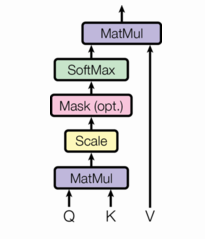 "Scaled Dot-Product Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V
$$



In [2]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, scale):
    super(ScaledDotProductAttention, self).__init__()
    self.scale=scale

  def forward(self, query, key, value, mask=None):
    """
    query:(batch_size, n_heads, query_len, head_dim),
    key:(batch_size, n_heads, key_len, head_dim),
    value:(batch_size, n_heads, value_len, head_dim)
    """
    alignment_score=torch.matmul(query, key.transpose(-2, -1)) #(batch_size, n_heads, query_len, value_len)
    alignment_score=alignment_score/self.scale

    if mask is not None:
      alignment_score=alignment_score.masked_fill(mask==0, float('-inf'))

    attention_probab=F.softmax(alignment_score, dim=-1)

    output=torch.matmul(attention_probab, value)

    return output

### Multi-Head Attention

![multi_head_attention](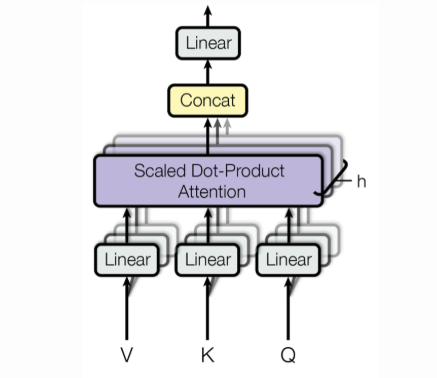 "Multi-Head Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O \\
\text{where}\ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
W_i^Q \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^K \in \mathbb{R}^{\mathrm{d_{model}\times d_k}}, W_i^V \in \mathbb{R}^{\mathrm{d_{model}\times d_v}}, W_i^O \in \mathbb{R}^{\mathrm{hd_v\times d_{model}}}
$$



In [3]:
class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, d_model):
    super(MultiHeadAttention, self).__init__()
    self.n_heads=n_heads
    self.d_model=d_model
    self.d_k=self.d_v=d_model//n_heads

    self.W_q=nn.Linear(d_model, d_model, bias=False)
    self.W_k=nn.Linear(d_model, d_model, bias=False)
    self.W_v=nn.Linear(d_model, d_model, bias=False)
    self.W_o=nn.Linear(d_model, d_model)

    self.attention=ScaledDotProductAttention(np.sqrt(self.d_k))

  def split_heads(self, x):
    """
    x:(batch_size, seq_len, d_model)

    """
    batch_size=x.size(0)
    x=x.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2) # (batch_size, n_heads, seq_len, d_k)

    return x # x:(batch_size, n_heads, seq_len, head_dim)

  def group_heads(self, x):
    """
    x:(batch_size, n_heads, seq_len, head_dim)
    """

    batch_size=x.size(0)
    x=x.transpose(1, 2).contigous().view(batch_size, -1, self.n_heads * self.d_k)
    return x #  x:(batch_size, seq_len, d_model)

  def forward(self, query, key, value):
    # Applying linear projection to Q,K, V
    Q=self.split_heads(self.W_q(query)) # (batch_size, n_heads, query_len, head_dim)
    K=self.split_heads(self.W_k(key))   # (batch_size, n_heads, key_len, head_dim)
    V=self.split_heads(self.W_v(value)) # (batch_size, n_heads, value_len, head_dim)


    #calculating attention weights and context vector for each of the heads
    x, attention=self.attention(Q, K, V)
     # x: (batch_size, n_heads, query_len, head_dim)
     # attn: (batch_size, n_heads, query_len, value_len)

    #concatenation of all heads
    x=self.group_heads(x) # (batch_size, query_len, d_model)

    #applying lienar projection
    x=self.W_o(x) # (batch_size, query_len, d_model)

    return x, attention
    # x: (batch_size, query_len, d_model)
    # attn: (batch_size, n_heads, query_len, value_len)

### Positional-wise Feed-Forward NN


$$
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
$$

In [4]:
class PositionWiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
    super(PositionWiseFeedForward, self).__init__()
    self.d_model=d_model
    self.d_ff=d_ff

    self.w_1=nn.Linear(d_model, d_ff)
    self.w_2=nn.Linear(d_ff, d_model)

  def forward(self, x):
    """
    x:(batch_size,. seq_len, d_model)
    """
    x=F.relu(self.w_1(x))
    x=self.w_2(x)

    return x

### Positional Encoding


$$
\begin{aligned}
\text{PE}_{(pos, 2i)} &= \text{sin}(\frac{pos}{10000^{2i/d_{model}}}) \\
\text{PE}_{(pos, 2i + 1)} &= \text{cos}(\frac{pos}{10000^{2i/d_{model}}})
\end{aligned}
$$


In [5]:
class PositionalEncoding(nn.Module):
  """
  Sinusoidal implementation is done
  """
  def __init__(self, d_model, max_len):
    super(PositionalEncoding, self).__init__()
    self.d_model=d_model
    self.max_len=max_len

    # computation of positional encoding:
    positional_encoding=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #(max_len, 1)
    div_term=torch.exp(
        torch.arange(0, d_model, 2).float() * (-math.log(1000.0)/d_model)
    )
    positional_encoding[:, 0::2]=torch.sin(position, * div_term)
    positional_encoding[:, 1::2]=torch.cos(position * div_term)
    positional_encoding=positional_encoding.unsqueeze(0).transpose(0, 1)
    self.register_buffer('positional_encoding', positional_encoding)

  def forward(self, x):
    """
    x:(batch_size, seq_len, d_model)
    """
    x= x + self.positional_encoding[:x.size(0), :]
    return x

### Encoder

In [7]:
class EncoderLayer(nn.Module):
  """
  Encoder is made of self attention and feed forward neural network
  """
  def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
    super(EncoderLayer, self).__init__()
    self.d_model=d_model
    self.n_heads=n_heads
    self.d_ff=d_ff
    self.dropout_rate=dropout_rate

    self.attention_layer=MultiHeadAttention(d_model, n_heads)
    self.attention_layer_norm=nn.LayerNorm(d_model, eps=1e-6)

    self.ff_layer=PositionWiseFeedForward(d_model, d_ff)
    self.ff_layer_norm=nn.LayerNorm(d_model, eps=1e-6)

  def forward(self, x, mask):
    #applying self-attention:
    x1, _=self.attention_layer(x, x, x, mask) #batch_size, source_seq_len, d_model

    x=self.attention_layer_norm(x+self.dropout(x1))
    x1=self.ff_layer(x)
    x=self.ff_layer_norm(x+self.dropout(x1))
    return x  #batch_size, source_seq_len, d_model


In [8]:
class Encoder(nn.Module):
  """
  Encoder block is the stack of N identical encoder layer
  """
  def __init__(self, d_model, n_layers, n_heads, d_ff, pad_idx, vocab_size,
               dropout_rate=0.1, max_len=5000):
    super(Encoder, self).__init__()
    self.vocab_size=vocab_size
    self.d_model=d_model
    self.n_layers=n_layers
    self.n_heads=n_heads
    self.d_ff=d_ff
    self.pad_idx=pad_idx
    self.dropout_rate=dropout_rate
    self.max_len=max_len

    self.token_embedding=nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
    self.positional_embedding=PositionalEncoding(d_model, dropout_rate, max_len)
    self.layers=nn.ModuleList([
        EncoderLayer(d_model, n_heads, d_ff, dropout_rate)
        for _ in range(n_layers)
    ])

    self.layer_norm=nn.LayerNorm(d_model, eps=1e-6)

  def forward(self, x, mask):
    x=self.token_embedding(x)
    x=self.positional_embedding(x)

    for layer in self.layers:
      x=layer(x, mask)

    x=self.layer_norm(x)
    return x # batch_size, source_seq_len, d_model